# Day 3: LSTM Networks

## Learning Objectives
- Understand LSTM gates and cell state
- Implement LSTM from scratch
- Train LSTM for financial prediction

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded!")
print("📚 Day 3: LSTM Networks")

✅ Libraries loaded!
📚 Day 3: LSTM Networks


## Part 1: LSTM Gates Explained

LSTM has **3 gates** controlling information flow:

1. **Forget Gate**: What to discard from memory
2. **Input Gate**: What new information to store
3. **Output Gate**: What to output

In [2]:
# ============================================================
# LSTM CELL FROM SCRATCH
# ============================================================

print("LSTM CELL IMPLEMENTATION")
print("="*60)

class LSTMCell(nn.Module):
    """Single LSTM cell for educational purposes."""
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Combined weights for all 4 gates (i, f, g, o)
        self.W_x = nn.Linear(input_size, 4 * hidden_size)
        self.W_h = nn.Linear(hidden_size, 4 * hidden_size)
        
    def forward(self, x, h_prev, c_prev):
        # Compute all gates at once
        gates = self.W_x(x) + self.W_h(h_prev)
        
        # Split into 4 gates
        i = torch.sigmoid(gates[:, :self.hidden_size])                    # Input gate
        f = torch.sigmoid(gates[:, self.hidden_size:2*self.hidden_size])  # Forget gate
        o = torch.sigmoid(gates[:, 2*self.hidden_size:3*self.hidden_size]) # Output gate
        g = torch.tanh(gates[:, 3*self.hidden_size:])                     # Cell candidate
        
        # Update cell state: C_t = f * C_{t-1} + i * g
        c = f * c_prev + i * g
        
        # Update hidden state: h_t = o * tanh(C_t)
        h = o * torch.tanh(c)
        
        return h, c, {'i': i, 'f': f, 'o': o, 'g': g}


class LSTMModel(nn.Module):
    """Complete LSTM model."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, return_gates=False):
        batch_size, seq_len, _ = x.shape
        
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c = torch.zeros(batch_size, self.hidden_size, device=x.device)
        
        gate_history = []
        for t in range(seq_len):
            h, c, gates = self.cell(x[:, t, :], h, c)
            gate_history.append(gates)
            
        output = self.fc(h)
        
        if return_gates:
            return output, gate_history
        return output

# Test
model = LSTMModel(input_size=3, hidden_size=32, output_size=1)
x = torch.randn(4, 20, 3)
output, gates = model(x, return_gates=True)

print(f"Input:  {x.shape}")
print(f"Output: {output.shape}")
print(f"Gates:  {len(gates)} timesteps")

LSTM CELL IMPLEMENTATION
Input:  torch.Size([4, 20, 3])
Output: torch.Size([4, 1])
Gates:  20 timesteps


GATE ACTIVATION VISUALIZATION


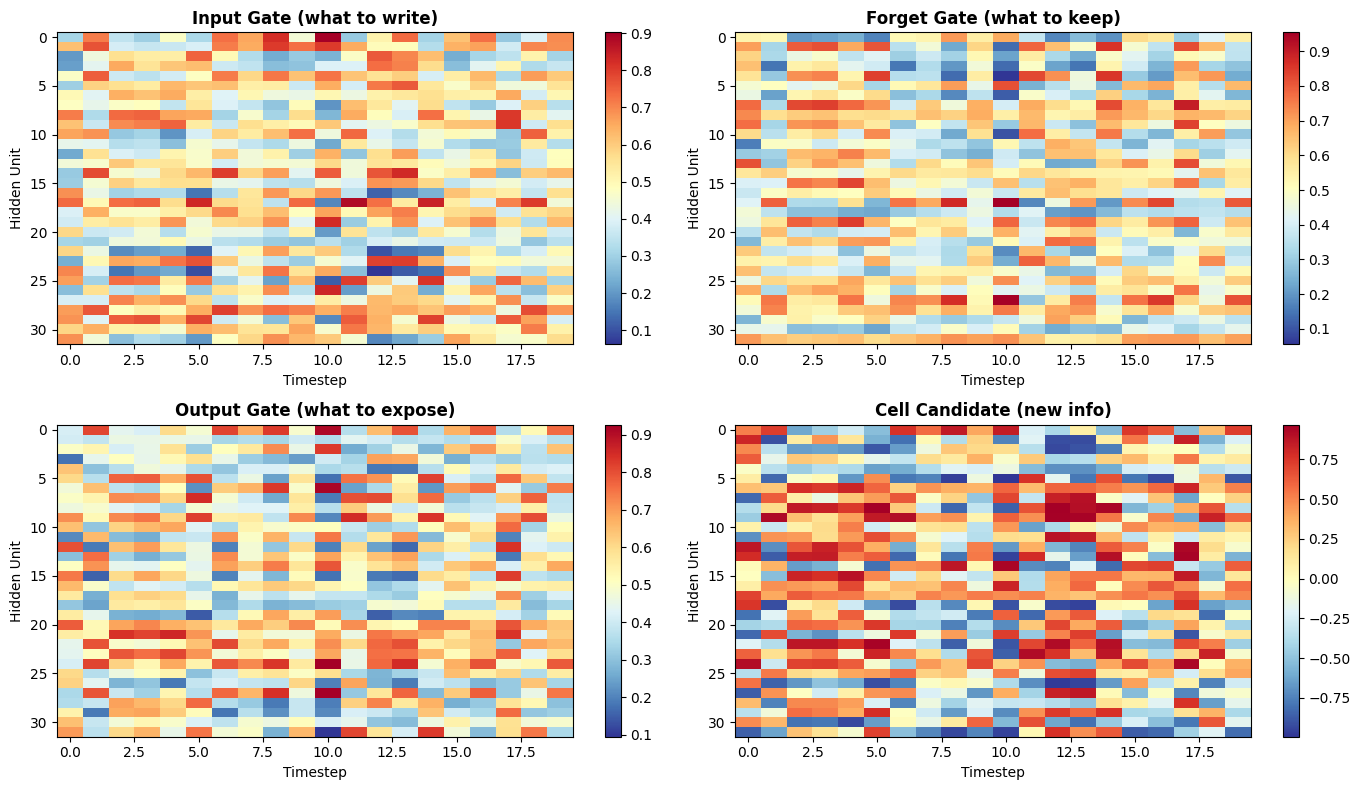


💡 Forget gate near 1 → preserve memory (long-term dependencies!)


In [3]:
# ============================================================
# VISUALIZE GATE ACTIVATIONS
# ============================================================

print("GATE ACTIVATION VISUALIZATION")
print("="*60)

# Single sample through model
x_sample = torch.randn(1, 20, 3)
_, gates = model(x_sample, return_gates=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

gate_names = ['i', 'f', 'o', 'g']
titles = ['Input Gate (what to write)', 'Forget Gate (what to keep)',
          'Output Gate (what to expose)', 'Cell Candidate (new info)']

for idx, (name, title) in enumerate(zip(gate_names, titles)):
    ax = axes[idx // 2, idx % 2]
    
    gate_vals = torch.stack([g[name][0] for g in gates]).detach().numpy()
    
    im = ax.imshow(gate_vals.T, aspect='auto', cmap='RdYlBu_r')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Hidden Unit')
    ax.set_title(title, fontweight='bold')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("\n💡 Forget gate near 1 → preserve memory (long-term dependencies!)")

## Part 2: LSTM for Financial Prediction

In [4]:
# ============================================================
# PREPARE FINANCIAL DATA
# ============================================================

print("PREPARING FINANCIAL DATA")
print("="*60)

# Generate synthetic returns with regime changes
np.random.seed(42)
n_days = 1000

returns = []
regime = 'low_vol'

for i in range(n_days):
    # Regime switching
    if np.random.random() < 0.02:
        regime = 'high_vol' if regime == 'low_vol' else 'low_vol'
    
    vol = 0.02 if regime == 'high_vol' else 0.01
    drift = -0.0002 if regime == 'high_vol' else 0.0003
    
    ret = drift + np.random.normal(0, vol)
    returns.append(ret)

returns = np.array(returns)

# Create features
def create_features(returns):
    df = pd.DataFrame({'returns': returns})
    df['vol_5d'] = df['returns'].rolling(5).std()
    df['vol_20d'] = df['returns'].rolling(20).std()
    df['mom_5d'] = df['returns'].rolling(5).mean()
    df['mom_20d'] = df['returns'].rolling(20).mean()
    return df.dropna().values

features = create_features(returns)

# Create sequences
seq_length = 20
X, y = [], []
for i in range(len(features) - seq_length):
    X.append(features[i:i+seq_length])
    y.append(features[i+seq_length, 0])  # Next return

X = np.array(X)
y = np.array(y)

# Normalize
scaler = StandardScaler()
X_flat = X.reshape(-1, X.shape[-1])
X_flat = scaler.fit_transform(X_flat)
X = X_flat.reshape(X.shape)

# Split
split = int(len(X) * 0.8)
X_train, X_test = torch.FloatTensor(X[:split]), torch.FloatTensor(X[split:])
y_train, y_test = torch.FloatTensor(y[:split]).unsqueeze(1), torch.FloatTensor(y[split:]).unsqueeze(1)

print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")

PREPARING FINANCIAL DATA
Training: torch.Size([768, 20, 5])
Test: torch.Size([193, 20, 5])


In [5]:
# ============================================================
# TRAIN LSTM
# ============================================================

print("TRAINING LSTM")
print("="*60)

# Use PyTorch's optimized LSTM
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

model = LSTMPredictor(input_size=5, hidden_size=64, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32, shuffle=True
)

history = {'train': [], 'test': []}

print("Training...")
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X_b), y_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(X_test), y_test).item()
    
    history['train'].append(epoch_loss / len(train_loader))
    history['test'].append(test_loss)
    
    if (epoch + 1) % 25 == 0:
        print(f"  Epoch {epoch+1}: Train={history['train'][-1]:.6f}, Test={test_loss:.6f}")

print("\n✅ Training complete!")

TRAINING LSTM
Training...
  Epoch 25: Train=0.000267, Test=0.000335
  Epoch 50: Train=0.000257, Test=0.000387
  Epoch 75: Train=0.000231, Test=0.000597
  Epoch 100: Train=0.000193, Test=0.000776

✅ Training complete!


EVALUATION
Correlation: -0.0787
Direction Accuracy: 55.4%
Strategy Sharpe: 0.52
Strategy Return: 8.7%
Market Return: -3.1%


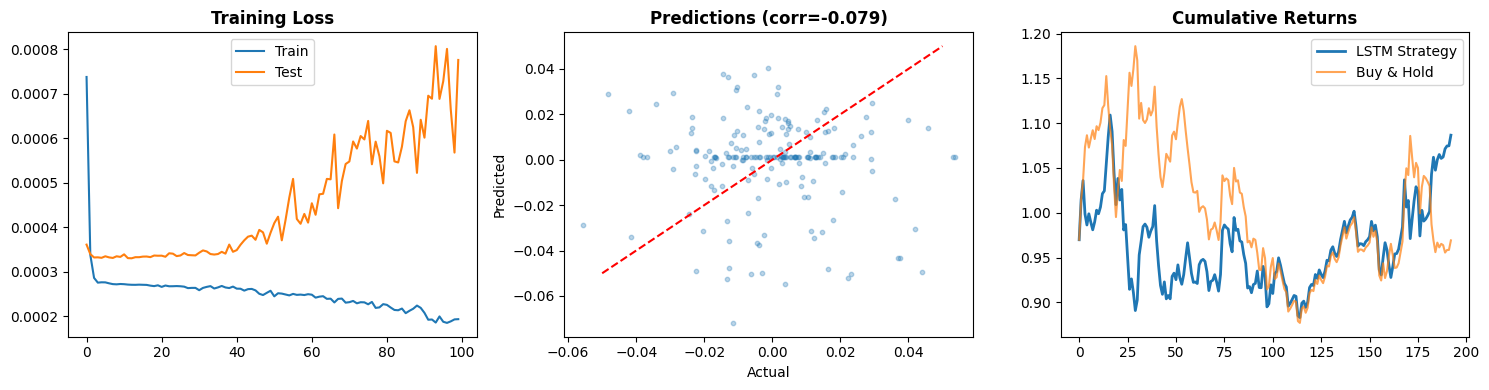

In [6]:
# ============================================================
# EVALUATE
# ============================================================

print("EVALUATION")
print("="*60)

model.eval()
with torch.no_grad():
    preds = model(X_test).numpy().flatten()
    actuals = y_test.numpy().flatten()

correlation = np.corrcoef(preds, actuals)[0, 1]
direction_acc = np.mean(np.sign(preds) == np.sign(actuals))

print(f"Correlation: {correlation:.4f}")
print(f"Direction Accuracy: {direction_acc*100:.1f}%")

# Trading simulation
strategy_returns = actuals * np.sign(preds)
cum_strategy = np.cumprod(1 + strategy_returns)
cum_market = np.cumprod(1 + actuals)

sharpe = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

print(f"Strategy Sharpe: {sharpe:.2f}")
print(f"Strategy Return: {(cum_strategy[-1]-1)*100:.1f}%")
print(f"Market Return: {(cum_market[-1]-1)*100:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train'], label='Train')
axes[0].plot(history['test'], label='Test')
axes[0].set_title('Training Loss', fontweight='bold')
axes[0].legend()

axes[1].scatter(actuals, preds, alpha=0.3, s=10)
axes[1].plot([-0.05, 0.05], [-0.05, 0.05], 'r--')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Predictions (corr={correlation:.3f})', fontweight='bold')

axes[2].plot(cum_strategy, label='LSTM Strategy', linewidth=2)
axes[2].plot(cum_market, label='Buy & Hold', alpha=0.7)
axes[2].set_title('Cumulative Returns', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

In [7]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║              DAY 3 COMPLETE: LSTM NETWORKS                       ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ LSTM gates: Input, Forget, Output                            ║
║  ✓ Cell state for long-term memory                              ║
║  ✓ Implemented LSTM from scratch                                ║
║  ✓ Financial prediction with LSTM                               ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 4 - GRU Networks
""")


╔══════════════════════════════════════════════════════════════════╗
║              DAY 3 COMPLETE: LSTM NETWORKS                       ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ LSTM gates: Input, Forget, Output                            ║
║  ✓ Cell state for long-term memory                              ║
║  ✓ Implemented LSTM from scratch                                ║
║  ✓ Financial prediction with LSTM                               ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 4 - GRU Networks

